# Summary

-----

# Imports

In [1]:
%run imports.ipynb

2016-08-11 14:06:41.015586


In [2]:
print2 = ascommon.df_tools.print2

In [3]:
NOTEBOOK_NAME = 'interface_data_statistics'

# Load data

In [4]:
db = datapkg.MySQL(
    os.environ['DATAPKG_CONNECTION_STR'], 
    NOTEBOOK_NAME, 
    None, 
    echo=False)

### Load DATA

This includes both calculated (with $\Delta \Delta G$ prediction) and not calculated (without $\Delta \Delta G$ prediction).

In [5]:
with open('interface_load_data/DATA.pkl', 'rb') as ifh:
    DATA = pickle.load(ifh)

In [6]:
for key in DATA:
    if key in ['humsavar', 'clinvar', 'cosmic']:
        print(key)
        DATA[key] = (
            DATA[key][
                (DATA[key]['uniprot_id_1'].isnull() | 
                 ~DATA[key]['uniprot_id_1'].str.contains('-').astype(bool)) &
                (DATA[key]['uniprot_id_2'].isnull() | 
                 ~DATA[key]['uniprot_id_2'].str.contains('-').astype(bool))
            ]
        )

cosmic
humsavar
clinvar


### Load DATA_DF

This only includes calculated mutations (with $\Delta \Delta G$ prediction).

In [7]:
DATA_DF = pd.read_pickle('interface_load_data/DATA_DF.pkl')
#DATA_DF['ddg_exp'] = DATA_DF['ddg_exp'].astype(float)

In [8]:
DATA_DF = (
    DATA_DF[
        (DATA_DF['uniprot_id_1'].isnull() | 
         ~DATA_DF['uniprot_id_1'].str.contains('-').astype(bool)) &
        (DATA_DF['uniprot_id_2'].isnull() | 
         ~DATA_DF['uniprot_id_2'].str.contains('-').astype(bool))
    ]
)

### Compare

In [9]:
DATA['cosmic'][['uniprot_id', 'uniprot_mutation']].drop_duplicates().shape
# 29691

(26907, 2)

In [10]:
DATA_DF[DATA_DF['dataset'] == 'cosmic'][['uniprot_id', 'uniprot_mutation']].drop_duplicates().shape
# 29691

(26907, 2)

# DATA

In [11]:
DATA.keys()

dict_keys(['kortemme_baker', 'cosmic', 'skempi', 'humsavar', 'clinvar', 'skempi_database', 'sahni_ppi_database', 'sahni_gpca_database'])

In [12]:
header_columns = ['kortemme_baker', 'skempi', 'skempi_database']
tail_columns = ['humsavar', 'clinvar', 'cosmic']

columns_all = (
    header_columns + 
    sorted(c for c in DATA.keys() if c not in header_columns and c not in tail_columns) +
    tail_columns
)
assert not set(DATA.keys()) - set(columns_all)

columns_nodiffseqi = (
    header_columns + 
    sorted(c for c in DATA.keys() if not c.endswith('_database') and 
           c not in header_columns and c not in tail_columns) +
    tail_columns
)

## Dataset overlap

### All columns

In [13]:
counts = {}
df_out = pd.DataFrame(columns=columns_all, index=columns_all, dtype=float)

for dataset_1 in columns_all:
    # print(dataset_1)
    df_1 = DATA[dataset_1].copy()
    # df_1 = df[df['dataset'] == dataset_1]
    mutation_set_1 = set(df_1['uniprot_id'].astype(str) + '.' + df_1['uniprot_mutation'].astype(str))
    counts[dataset_1] = len(set(
        df_1['pdb_id'].astype(str) + '.' + 
        df_1['uniprot_id'].astype(str) + '.' + 
        df_1['uniprot_mutation'].astype(str)))
    for dataset_2 in columns_all:
        # print('\t', dataset_2)
        df_2 = DATA[dataset_2].copy()
        # df_2 = df[df['dataset'] == dataset_2]
        mutation_set_2 = set(df_2['uniprot_id'].astype(str) + '.' + df_2['uniprot_mutation'].astype(str))
        frac_covered = 1 - len(mutation_set_1 - mutation_set_2) / len(mutation_set_1)
        df_out.loc[dataset_1, dataset_2] = frac_covered * 100.0
df_out.index = ['{}\n(n = {:.0f})'.format(x, counts[x]) for x in df_out.index]

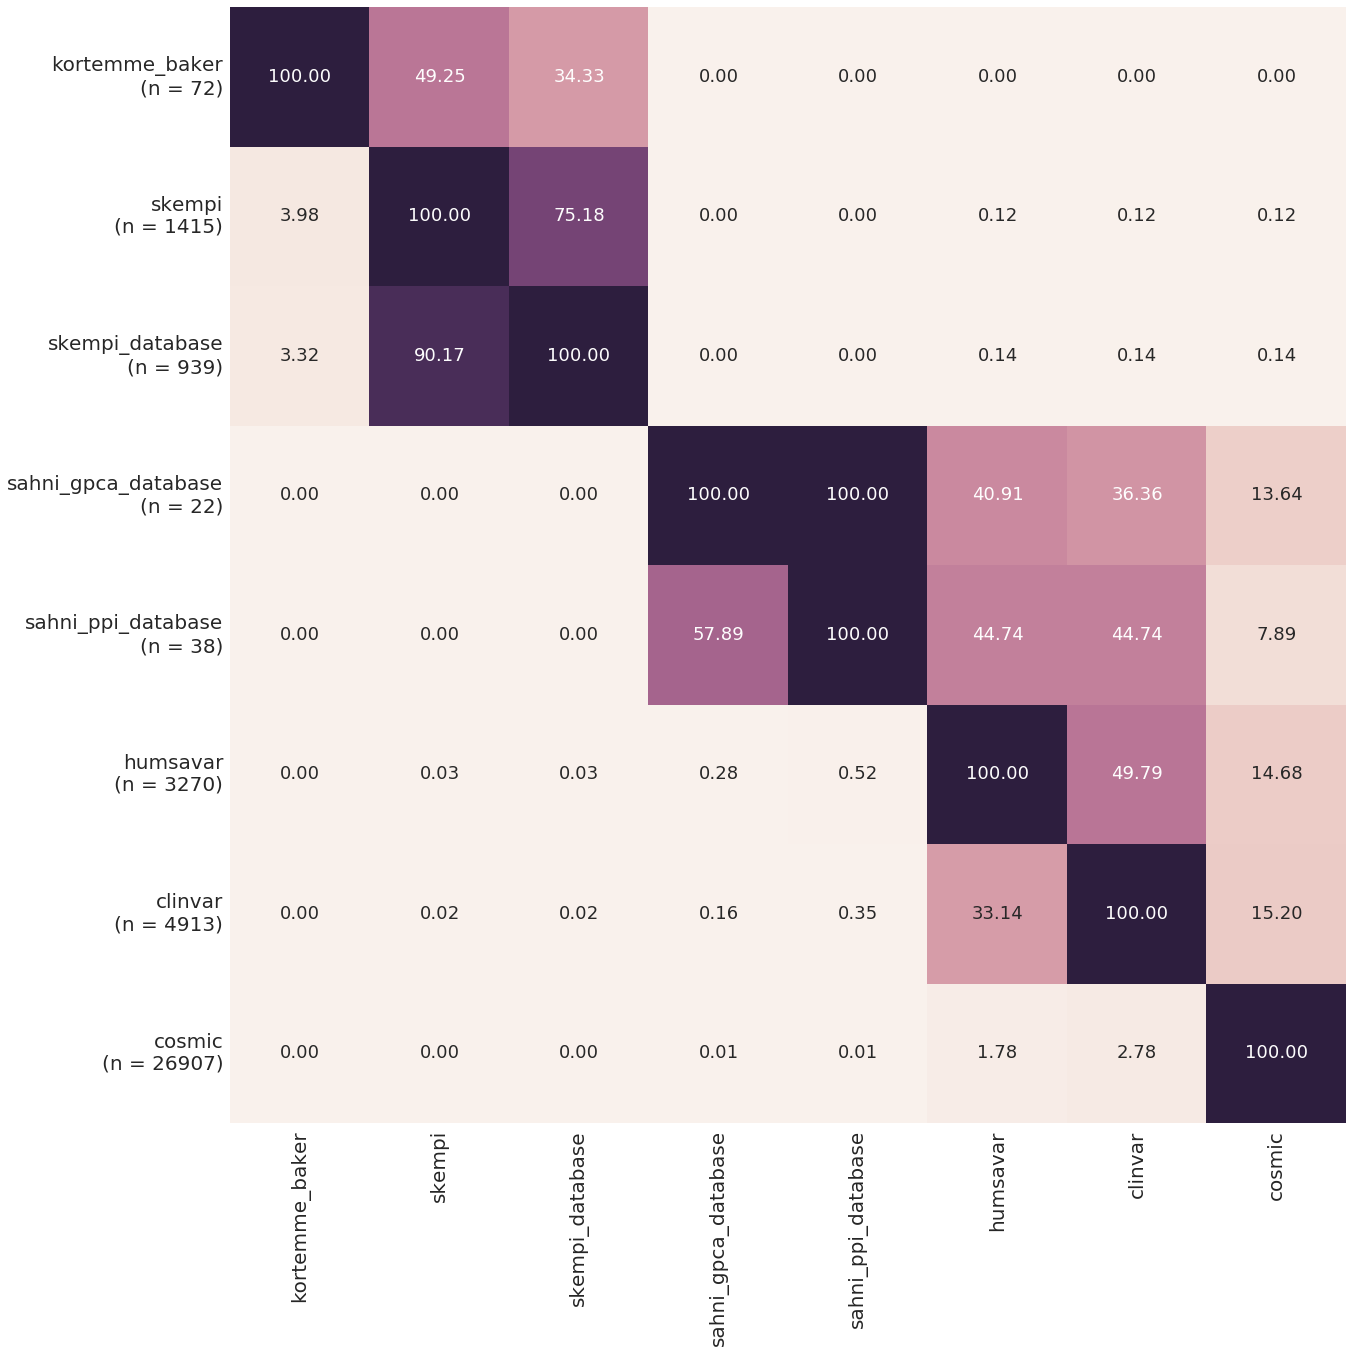

In [14]:
fg, ax = plt.subplots(figsize=(24, 20))
sns.heatmap(df_out, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})

### No diffseqi

In [15]:
name_mapping = {'taipale': 'sahni'}

counts = {}
df_out = pd.DataFrame(columns=columns_nodiffseqi, index=columns_nodiffseqi, dtype=float)

for dataset_1 in columns_nodiffseqi:
    # print(dataset_1)
    df_1 = DATA[dataset_1]
    # df_1 = df[df['dataset'] == dataset_1]
    mutation_set_1 = set(df_1['uniprot_id'].astype(str) + '.' + df_1['uniprot_mutation'].astype(str))
    counts[dataset_1] = len(set(
        df_1['pdb_id'].astype(str) + '.' + 
        df_1['uniprot_id'].astype(str) + '.' + 
        df_1['uniprot_mutation'].astype(str)))
    for dataset_2 in columns_nodiffseqi:
        # print('\t', dataset_2)
        df_2 = DATA[dataset_2]
        # df_2 = df[df['dataset'] == dataset_2]
        mutation_set_2 = set(df_2['uniprot_id'].astype(str) + '.' + df_2['uniprot_mutation'].astype(str))
        frac_covered = 1 - len(mutation_set_1 - mutation_set_2) / len(mutation_set_1)
        df_out.loc[dataset_1, dataset_2] = frac_covered * 100.0

# Format row and column names
df_out.index = ['{}\n(n = {:.0f})'.format(name_mapping.get(x, x), counts[x]) for x in df_out.index]
df_out.columns = [name_mapping.get(c, c) for c in df_out.columns]

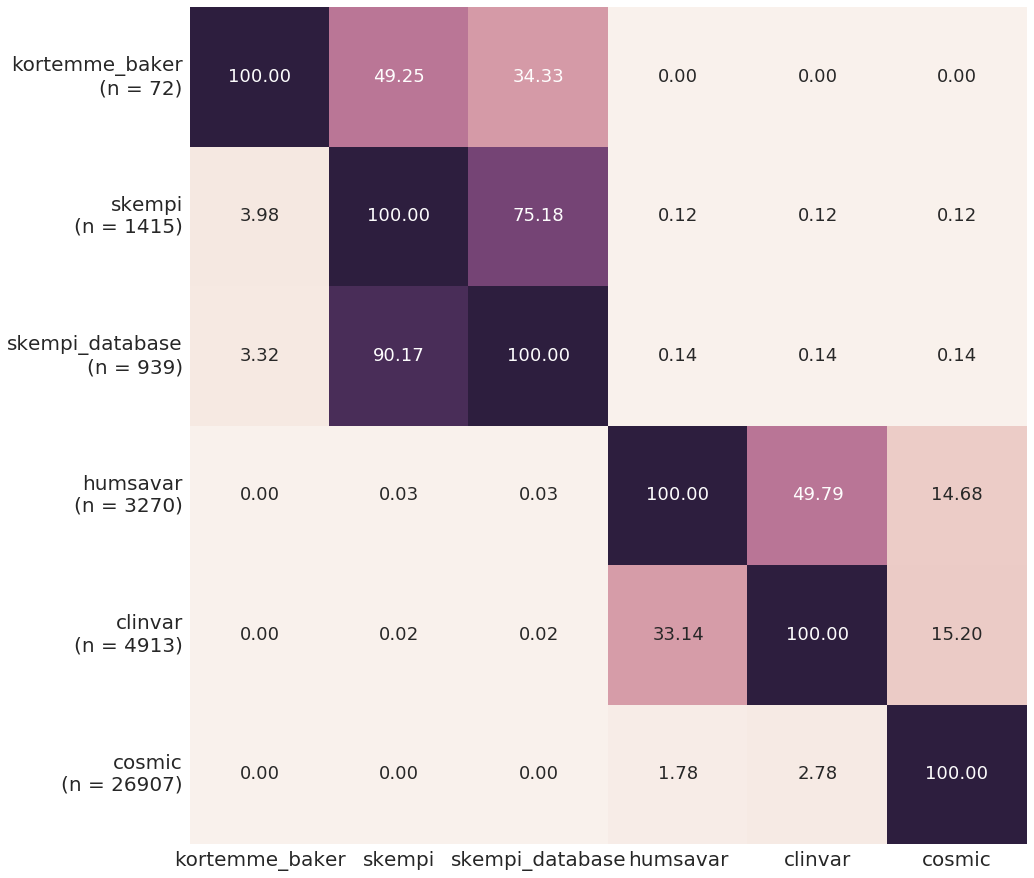

In [16]:
fg, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(df_out, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})
plt.savefig(op.join(NOTEBOOK_NAME, 'core_training_set_overlap_1.pdf'), bbox_inches='tight')

## Correlations

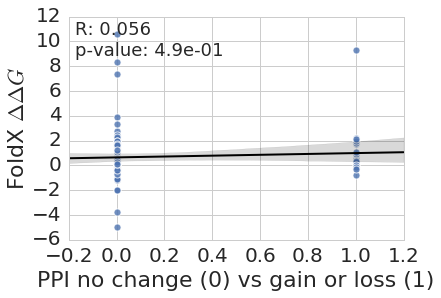

In [17]:
# Some validation to make sure that we 
fg, ax = plt.subplots()
ascommon.plotting_tools.make_plot_with_corr(
    x='ddg_exp', 
    y='dg_change',
    data=DATA_DF[DATA_DF['dataset'] == 'sahni_ppi'][['ddg_exp', 'dg_change']].drop_duplicates(), 
    ax=ax,
    corr_type='spearman'
)
plt.xlabel('PPI no change (0) vs gain or loss (1)')
plt.ylabel('FoldX $\Delta \Delta G$')

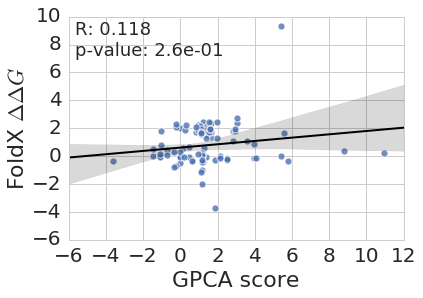

In [18]:
# Some validation to make sure that we 
fg, ax = plt.subplots()
ascommon.plotting_tools.make_plot_with_corr(
    x='ddg_exp', 
    y='dg_change',
    data=DATA_DF[DATA_DF['dataset'] == 'sahni_gpca'][['ddg_exp', 'dg_change']].drop_duplicates(), 
    ax=ax,
    corr_type='spearman'
)
plt.xlabel('GPCA score')
plt.ylabel('FoldX $\Delta \Delta G$')

### Correlation with Foldx

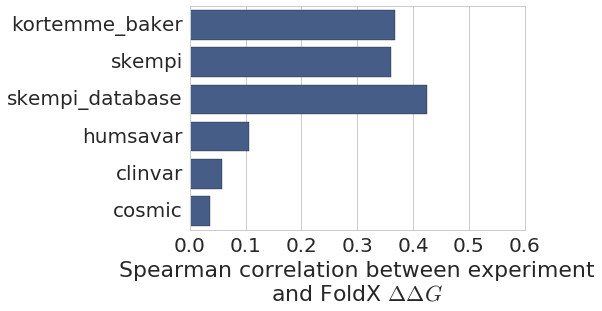

In [19]:
corrs = OrderedDict()
for table_name in columns_nodiffseqi:
    df = DATA[table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    df = df.dropna(subset=['dg_change', 'ddg_exp'])
    corrs[table_name] = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["denim blue"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand FoldX $\Delta \Delta G$')

### Correlation with Provean

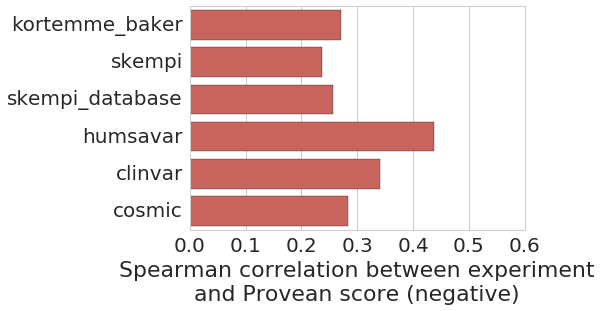

In [20]:
corrs = OrderedDict()
for table_name in columns_nodiffseqi:
    df = DATA[table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    else:
        df['ddg_exp'] = df['ddg_exp'].abs()
    df = df.dropna(subset=['provean_score', 'ddg_exp'])
    corrs[table_name] = -sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["pale red"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand Provean score (negative)')

# DATA_DF

In [21]:
DATA_DF.head(2)

,_index,alignment_coverage,alignment_filename_1,alignment_filename_2,alignment_identity,alignment_score,backbone_clash_change,backbone_clash_wt,backbone_hbond_change,backbone_hbond_wt,cath_id_1,cath_id_2,chain_1,chain_2,chain_modeller,cis_bond_change,cis_bond_wt,conserved_1,conserved_2,conserved_if_1,conserved_if_2,contact_distance_change,contact_distance_wt,coverage_1,coverage_2,coverage_if_1,coverage_if_2,dataset,db,ddg,ddg_exp,del_class_exp,del_score_exp,dg_change,dg_wt,disulfide_change,disulfide_wt,domain_contact_id,domain_contact_ids,electrostatic_kon_change,electrostatic_kon_wt,electrostatics_change,electrostatics_wt,energy_ionisation_change,energy_ionisation_wt,entropy_complex_change,entropy_complex_wt,entropy_mainchain_change,entropy_mainchain_wt,entropy_sidechain_change,entropy_sidechain_wt,gene_name,helix_dipole_change,helix_dipole_wt,id,identical_1,identical_2,identical_if_1,identical_if_2,idx,idx_x,idx_y,idxs,interacting_aa_1,interacting_aa_2,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,interface_dg,intraclashes_energy_1_change,intraclashes_energy_1_wt,intraclashes_energy_2_change,intraclashes_energy_2_wt,m_date_modified,matrix_score,max_seq_identity,mloop_entropy_change,mloop_entropy_wt,model_domain_def_1,model_domain_def_2,model_errors,model_file_mut,model_file_wt,model_filename,model_filename_mut,model_filename_wt,mut_date_modified,mutation,mutation_errors,mutation_modeller,norm_dope,number_of_residues,organism_name,partial_covalent_bonds_change,partial_covalent_bonds_wt,partner_pdb_chain,partner_uniprot_id,path_to_data,pcv_hbond_change,pcv_hbond_self_change,pcv_hbond_self_wt,pcv_hbond_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_equal_self_wt,pcv_salt_equal_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_salt_opposite_self_wt,pcv_salt_opposite_wt,pcv_vdw_change,pcv_vdw_self_change,pcv_vdw_self_wt,pcv_vdw_wt,pdb_chain,pdb_id,pdb_mutation,pfam_clan,pfam_id,protein_existence,protein_name,provean_score,rigids,score_1,score_2,score_if_1,score_if_2,score_if_total,score_overall,score_total,secondary_structure_change,secondary_structure_wt,sequence_version,sidechain_hbond_change,sidechain_hbond_wt,sloop_entropy_change,sloop_entropy_wt,solvation_hydrophobic_change,solvation_hydrophobic_wt,solvation_polar_change,solvation_polar_wt,solvent_accessibility_change,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,t_date_modified,template_errors,torsional_clash_change,torsional_clash_wt,uniprot_domain_id_1,uniprot_domain_id_2,uniprot_domain_pair_id,uniprot_domain_pair_id_old,uniprot_id,uniprot_id_1,uniprot_id_2,uniprot_mutation,uniprot_name,uniprot_sequence,van_der_waals_change,van_der_waals_clashes_change,van_der_waals_clashes_wt,van_der_waals_wt,water_bridge_change,water_bridge_wt
2,NaN,0.562623,Q9NPD8_4ii2C.aln,A0AVT1_4ii2A.aln,0.47305,0.265759,0.0,7.90647,0.0,-4.20821,4ii2C00,4ii2A01,A,B,B,0.0,0.0,NaN,NaN,NaN,NaN,0.46396,8.74830,0.948052,0.177193,NaN,NaN,clinvar,NaN,0.021077,NaN,0.0,-0.515,0.06980,18.13320,0.0,0.00000,158108,None,0.063795,-0.545098,0.06694,-4.72785,0.0,4.440890e-16,0.0,2.384,0.0,5.31006,-0.061,14.28030,NaN,0.0,-0.098222,NaN,0.4315,0.5146,NaN,NaN,NaN,NaN,NaN,NaN,"27,28,60,63,64,67,69,70,71,78,80,81,82,84,85,8...","149,153,164,175,176,177,277,278,279,293,298,30...",NaN,NaN,NaN,None,-0.296,759.763,0.0,132.6660,2014-12-31 07:56:18,0.0,60.0,0.0,0.0,1:154,35:603,None,NaN,NaN,Q9NPD8_A0AVT1_4ii2CA.pdb,A0AVT1_R175H/MUT_RepairPDB_Q9NPD8_A0AVT1_4ii2C...,A0AVT1_R175H/WT_RepairPDB_Q9NPD8_A0AVT1_4ii2CA...,2015-06-11 11:49:17,NaN,None,R295H,2.268230,723.0,NaN,0.0,0.0,None,None,human/Q9N/PD/Q9NPD8/UQ_con.6-146/NADP_Rossmann...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,None,None,None,NaN,NaN,NaN,NaN,0.713,None,0.436033,0.095484,NaN,NaN,NaN,NaN,0.0416341,0,0,NaN,0.0,-9.29155,0.0,0.0,0.0000,-29.8790,0.0000,45.7736,-1.5798,92.0837,"1857.62,-216.556,-164.735,-778.533,-31.5374,12...","1857.29,-216.556,-164.735,-778.719,-31.5374,12...",2014-12-09 06:52:05,None,0.

In [22]:
DATA_DF['dataset'].drop_duplicates().tolist()

['clinvar', 'cosmic', 'humsavar', 'skempi', 'sahni_ppi', 'sahni_gpca']

In [23]:
datasets = [
    'skempi',
    'sahni_ppi',
    'sahni_gpca',
    'humsavar',
    'clinvar',
    'cosmic'
]

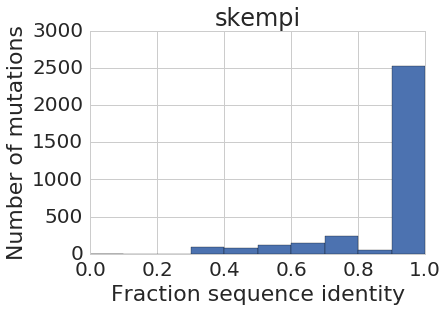

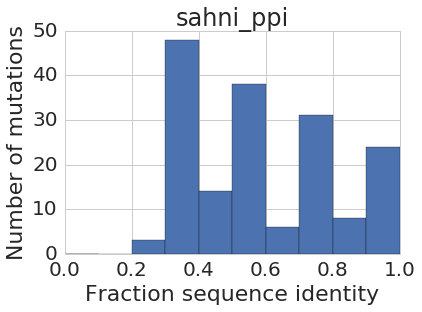

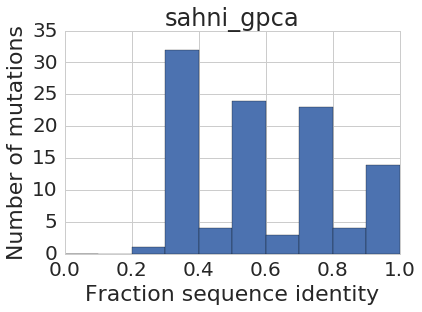

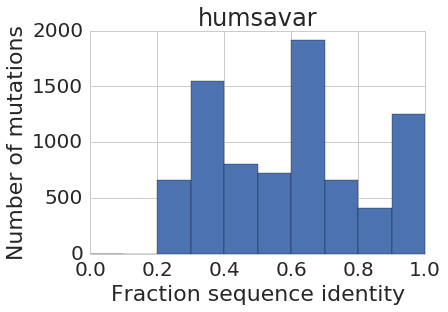

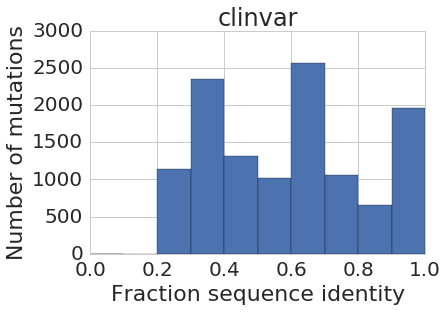

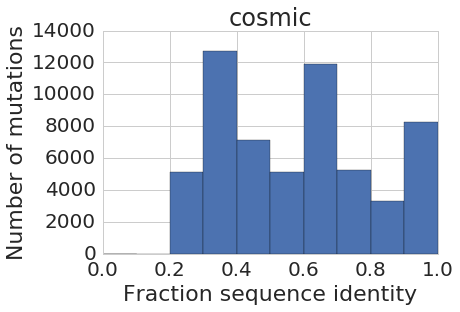

In [24]:
# Histogram sequence identities
for dataset in datasets:
    plt.figure()
    DATA_DF[DATA_DF['dataset'] == dataset]['alignment_identity'].hist(range=(0, 1), bins=10)
    plt.title(dataset)
    plt.xlabel("Fraction sequence identity")
    plt.ylabel("Number of mutations")

## Dataset overlap

In [25]:
columns_training_set = ['skempi', 'sahni_ppi', 'sahni_gpca', 'humsavar', 'clinvar', 'cosmic']

In [26]:
counts = {}
df = DATA_DF.dropna(subset=['ddg']).copy()
df_out = pd.DataFrame(columns=columns_training_set, index=columns_training_set, dtype=float)

for dataset_1 in columns_training_set:
    # print(dataset_1)
    df_1 = df[df['dataset'] == dataset_1]
    mutation_set_1 = set(df_1['uniprot_id'].astype(str) + '.' + df_1['uniprot_mutation'].astype(str))
    counts[dataset_1] = len(set(
        df_1['pdb_id'].astype(str) + '.' + 
        df_1['uniprot_id'].astype(str) + '.' + 
        df_1['uniprot_mutation'].astype(str)))
    for dataset_2 in columns_training_set:
        # print('\t', dataset_2)
        df_2 = df[df['dataset'] == dataset_2]
        mutation_set_2 = set(df_2['uniprot_id'].astype(str) + '.' + df_2['uniprot_mutation'].astype(str))
        frac_covered = 1 - len(mutation_set_1 - mutation_set_2) / len(mutation_set_1)
        df_out.loc[dataset_1, dataset_2] = frac_covered * 100.0
df_out.index = ['{}\n(n = {:.0f})'.format(x, counts[x]) for x in df_out.index]

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Text yticklabel objects>)

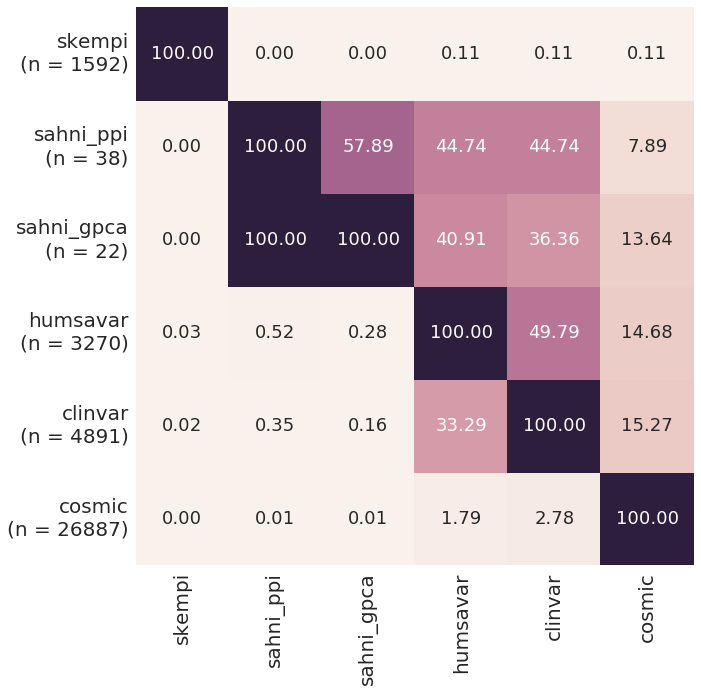

In [27]:
fg, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_out, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})
plt.yticks(rotation='horizontal')

## Correlations

### Correlation with FoldX

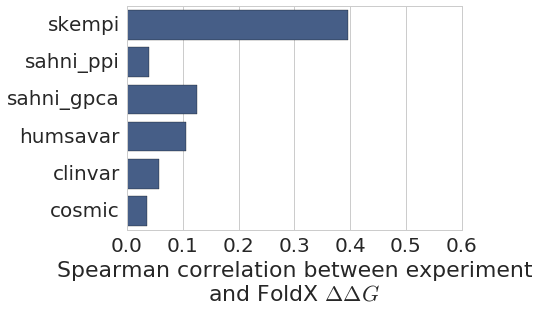

In [28]:
corrs = OrderedDict()
for table_name in columns_training_set:
    df = DATA_DF[DATA_DF['dataset'] == table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    df = df.dropna(subset=['dg_change', 'ddg_exp'])
    corrs[table_name] = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["denim blue"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand FoldX $\Delta \Delta G$')

### Correlation with Provean

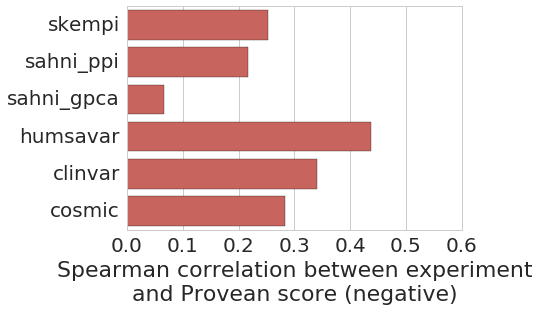

In [29]:
corrs = OrderedDict()
for table_name in columns_training_set:
    df = DATA_DF[DATA_DF['dataset'] == table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    else:
        df['ddg_exp'] = df['ddg_exp'].abs()
    df = df.dropna(subset=['provean_score', 'ddg_exp'])
    corrs[table_name] = -sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["pale red"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand Provean score (negative)')

In [30]:
cosmic_1 = DATA['cosmic'].copy()
cosmic_2 = DATA_DF[DATA_DF['dataset'] == 'cosmic'].copy()
cosmic_3 = cosmic_1.drop_duplicates()
cosmic_4 = (
    cosmic_1.drop_duplicates(
        subset=['uniprot_id', 'uniprot_domain_id', 'uniprot_mutation'], 
        keep='first')
)
cosmic_5 = (
    cosmic_1.drop_duplicates(
        subset=['uniprot_id', 'uniprot_mutation'], 
        keep='first')
)

KeyError: 'uniprot_domain_id'

In [ ]:
print(cosmic_1.shape)
print(cosmic_2.shape, '<--')
print(cosmic_3.shape)
print(cosmic_4.shape, '<--')
print(cosmic_5.shape)

In [ ]:
tmp = cosmic_1[['del_class_exp', 'dg_change']].dropna()
tmp = tmp.dropna(subset=['del_class_exp', 'dg_change'])
sp.stats.spearmanr(tmp['del_class_exp'], tmp['dg_change'])

In [ ]:
tmp = cosmic_2[['del_class_exp', 'dg_change']].dropna()
sp.stats.spearmanr(tmp['del_class_exp'], tmp['dg_change'])

In [ ]:
tmp = cosmic_3[['del_class_exp', 'dg_change']].dropna()
sp.stats.spearmanr(tmp['del_class_exp'], tmp['dg_change'])

In [ ]:
tmp = cosmic_4[['del_class_exp', 'dg_change']].dropna()
sp.stats.spearmanr(tmp['del_class_exp'], tmp['dg_change'])

In [ ]:
tmp = cosmic_5[['del_class_exp', 'dg_change']].dropna()
sp.stats.spearmanr(tmp['del_class_exp'], tmp['dg_change'])

In [ ]:
corrs['cosmic']